# 深度神经网络应用--图像分类

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

np.random.seed(1)

数据集

In [2]:
'''
load dataset
'''
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1,class = cat


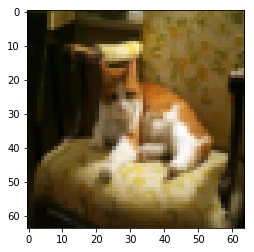

In [5]:
'''
example of a picture
'''
index = 7
plt.imshow(train_x_orig[index])
print("y = " + str(train_y[0, index]) + ",class = " + classes[train_y[0, index]].decode("utf-8"))

In [6]:
# explore your dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print("Number of training examples : " + str(m_train))
print("Number of testing examples : " + str(m_test))
print("Each image is of size : (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x_orig shape: " + str(train_x_orig.shape))
print("train_y_shape : " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples : 209
Number of testing examples : 50
Each image is of size : (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y_shape : (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


在将图像输入到网络之前，需要对图像进行重塑和标准化

piexl image:(64, 64, 3) --> reshaped image vector

In [8]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# standardize data to have feature values between 0 and 1
train_x = train_x_flatten / 255
test_x = test_x_flatten / 255

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))
# 12288 等于 64*64*3 图像重塑的大小

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


模型的结构

两层神经网络：input --> linear --> relu --> linear -->sigmoid --> output

In [9]:
def initialize_parameters(n_x, n_h, n_y):
    '''
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Return:
    parameters -- python dictionary containing your parameters:
                  W1 -- weight matix of shape(n_h, n_x)
                  b1 -- bias vector of shape(n_h, 1)
                  W2 -- weight matix of shape(n_y, n_h)
                  b2 -- bias vector of shape(n_y, 1)
    '''
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.rand(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {
        "W1" : W1,
        "b1" : b1,
        "W2" : W2,
        "b2" : b2
    }
    return parameters

In [10]:
def linear_activation_forward(A_prev, W, b, activation):
    '''
     Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    
    '''
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [11]:
def compute_cost(AL, Y):
    '''
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    '''
    m = Y.shape[1]
    cost = -1 / m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL), axis = 1, keepdims = True)
    
    cost = np.squeeze(cost)
    return cost

In [12]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache) 
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [13]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] =  parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]
    ### END CODE HERE ###
        
    return parameters


In [14]:
n_x = 12288
n_h = 7
n_y = 1
layer_dims = (n_x, n_h, n_y)

In [15]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    '''
    Implements a two-layer neural network: linear->relu->linear->sigmoid
    '''
    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layer_dims
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    #loop(gradient descent)
    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = "sigmoid")
        
        # compute cost
        cost = compute_cost(A2, Y)
        
        #backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = "relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        parameters = update_parameters(parameters, grads, learning_rate)
        
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.694580681567555
Cost after iteration 100: 0.6484738362578264
Cost after iteration 200: 0.6374570442712648
Cost after iteration 300: 0.6124089532393932
Cost after iteration 400: 0.5737364063101996
Cost after iteration 500: 0.5302834802344892
Cost after iteration 600: 0.4875119360293109
Cost after iteration 700: 0.4387135322749838
Cost after iteration 800: 0.4058010588689439
Cost after iteration 900: 0.38663685306453544
Cost after iteration 1000: 0.3533364445631
Cost after iteration 1100: 0.3228177976034533
Cost after iteration 1200: 0.2798247246548228
Cost after iteration 1300: 0.23810280416030266
Cost after iteration 1400: 0.1771345327953275
Cost after iteration 1500: 0.15306602465747707
Cost after iteration 1600: 0.48293279808402884
Cost after iteration 1700: 0.11746763069354153
Cost after iteration 1800: 0.10185387910280602
Cost after iteration 1900: 0.08173788471954192
Cost after iteration 2000: 0.06827503556405977
Cost after iteration 2100: 0.0580103538147

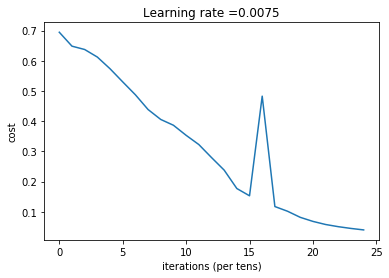

In [16]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [17]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [18]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.7
